# Paper Figures: Figure 4B - Dopamine AUC Aligned to Sigmoidal Transitions

This notebook generates extended Figure 4 showing dopamine (photometry) response aligned to the transition point where animals shift cluster membership. Uses sigmoidal transition points calculated in `src/assemble_all_data.py`.

**Figure 4B: Transition-Aligned Dopamine Response** — Photometry AUC heatmaps and time series for each rat, centered at their individual transition points.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from scipy.optimize import curve_fit

# Add src to path for importing local modules
sys.path.insert(0, str(Path("../src").resolve()))

from figure_config import (
    configure_matplotlib, COLORS, HEATMAP_CMAP,
    DATAFOLDER, RESULTSFOLDER, FIGSFOLDER,
    SAVE_FIGS
)
from figure_plotting import (
    save_figure, scale_vlim_to_data, make_heatmap
)

# Configure matplotlib
configure_matplotlib()
colors = COLORS  # Use shared color palette
custom_cmap = HEATMAP_CMAP  # Use shared colormap

## Load Assembled Data
Load the complete dataset with transition points and trial-aligned indices.

In [2]:
assembled_data_path = DATAFOLDER / "assembled_data.pickle"

with open(assembled_data_path, "rb") as f:
    data = dill.load(f)

# Extract main components
x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_behav = data["snips_behav"]
fits_df = data["fits_df"]
metadata = data.get("metadata", {})

print(f"Loaded assembled data from {assembled_data_path}")
print(f"\nData structure:")
print(f"  - x_array shape: {x_array.shape}")
print(f"  - x_array has trial_aligned column: {'trial_aligned' in x_array.columns}")
print(f"  - snips_photo shape: {snips_photo.shape}")
print(f"\nDeplete + 45NaCl subset:")
subset_full = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'")
subset_aligned = subset_full.dropna(subset=['trial_aligned'])
print(f"  - Total trials: {len(subset_full)}")
print(f"  - Trials with valid alignment: {len(subset_aligned)}")
print(f"  - Number of unique animals: {subset_aligned['id'].nunique()}")

Loaded assembled data from ..\data\assembled_data.pickle

Data structure:
  - x_array shape: (1960, 13)
  - x_array has trial_aligned column: True
  - snips_photo shape: (1960, 200)

Deplete + 45NaCl subset:
  - Total trials: 490
  - Trials with valid alignment: 392
  - Number of unique animals: 8


In [3]:
# Check time_moving in the FULL x_array
print("\nDIAGNOSTIC: time_moving in FULL x_array:")
print(f"  Mean (all trials): {x_array.time_moving.mean():.6f}")
print(f"  Mean (deplete+45NaCl): {subset_full.time_moving.mean():.6f}")
print(f"  Mean (subset_aligned): {subset_aligned.time_moving.mean():.6f}")

# Compare to snips_behav
from utils import get_time_moving
snips_behav_filtered = snips_behav[x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").index]
time_moving_recalc = get_time_moving(snips_behav_filtered, threshold=0.02)

print(f"\n  Time_moving RECALCULATED from snips_behav:")
print(f"    Mean: {time_moving_recalc.mean():.6f}")

print(f"\n  Difference: {abs(subset_full.time_moving.mean() - time_moving_recalc.mean()):.6f}")


DIAGNOSTIC: time_moving in FULL x_array:
  Mean (all trials): 0.259949
  Mean (deplete+45NaCl): 0.235449
  Mean (subset_aligned): 0.210332

  Time_moving RECALCULATED from snips_behav:
    Mean: 0.235449

  Difference: 0.000000


## Prepare Realigned Data

In [4]:
# Get the deplete + 45NaCl animals with valid transition fits
subset_aligned = (
    x_array
    .query("condition == 'deplete' & infusiontype == '45NaCl'")
    .dropna(subset=['trial_aligned'])
    .reset_index(drop=True)
    .sort_values(['id', 'trial'])
)

# Get animal info
animals = sorted(subset_aligned['id'].unique())
print(f"Animals with both transitions and deplete+45NaCl trials: {animals}")
print(f"Number of animals: {len(animals)}")

# Show summary statistics
print(f"\nTrial counts per animal:")
for animal in animals:
    n_trials = len(subset_aligned.query("id == @animal"))
    print(f"  {animal}: {n_trials} trials")

Animals with both transitions and deplete+45NaCl trials: ['PB26', 'PB30', 'PB31', 'PB46', 'PB71', 'PB72', 'PB73', 'PB75']
Number of animals: 8

Trial counts per animal:
  PB26: 49 trials
  PB30: 49 trials
  PB31: 49 trials
  PB46: 49 trials
  PB71: 49 trials
  PB72: 49 trials
  PB73: 49 trials
  PB75: 49 trials


## Figure 4B: Transition-Aligned Heatmaps

## Helper Functions for Plotting

In [5]:
# Define sigmoid function for fitting
def sigmoid(x, L, x0, k, b):
    """4-parameter sigmoid function."""
    return L / (1 + np.exp(-k * (x - x0))) + b


def plot_auc_and_sigmoid(df, column, ax=None, first_trial=0, include_steepness=True):
    """Plot AUC data grouped by column with sigmoid fit."""
    if ax is None:
        f, ax = plt.subplots(figsize=(3, 3))

    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    sd = df.groupby(column).std(numeric_only=True).auc_snips.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[3], linestyle="", marker="o", markersize=5, 
            markerfacecolor="white", alpha=0.5)
    ax.fill_between(x, y - sem, y + sem, color=colors[3], alpha=0.1)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[3], lw=2, linestyle="--")
        if include_steepness:
            ax.text(first_trial, np.max(y) * 0.9, f"k = {popt[2]:.2f}", 
                    color=colors[3], fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return popt
    except Exception as e:
        print(f"Failed to fit sigmoid: {e}")
        return None

    sns.despine(ax=ax, offset=5)
    ax.set_ylabel("Dopamine AUC")
    ax.set_xlabel("Trials")


def plot_realigned_behaviour(df, column, ax=None, first_trial=0, include_steepness=False):
    """Plot behavior (time_moving) grouped by column with sigmoid fit."""
    if ax is None:
        f, ax = plt.subplots(figsize=(3, 3))

    mean = df.groupby(column).mean(numeric_only=True).time_moving
    sd = df.groupby(column).std(numeric_only=True).time_moving.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[1], linestyle="", marker="o", markersize=5, 
            markerfacecolor="white", alpha=0.5)
    ax.fill_between(x, y - sem, y + sem, color=colors[1], alpha=0.1)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), 1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color=colors[1], lw=2, linestyle="--")
        if include_steepness:
            ax.text(first_trial, np.max(y) * 0.9, f"k = {popt[2]:.2f}", 
                    color=colors[1], fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        return popt
    except Exception as e:
        print(f"Failed to fit sigmoid: {e}")
        return None

    sns.despine(ax=ax, offset=5, right=True)
    ax.set_yticks([])
    ax.set_ylabel("Time Moving")

## DIAGNOSTIC: Check time_moving column

In [6]:
print("DIAGNOSTIC: Checking subset_aligned before fitting")
print(f"subset_aligned shape: {subset_aligned.shape}")
print(f"subset_aligned columns: {list(subset_aligned.columns)}")
print(f"\ntime_moving column:")
print(f"  Mean: {subset_aligned.time_moving.mean():.6f}")
print(f"  Min: {subset_aligned.time_moving.min():.6f}")  
print(f"  Max: {subset_aligned.time_moving.max():.6f}")
print(f"  Non-null count: {subset_aligned.time_moving.notna().sum()}")

# Check if time_moving is already in x_array or needs to be calculated
print(f"\nIs 'time_moving' in x_array columns? {'time_moving' in x_array.columns}")

# Group by trial_aligned just like the figure will
movement_by_trial_realigned = subset_aligned.groupby('trial_aligned')['time_moving'].mean()
print(f"\nGrouped movement_by_trial_realigned:")
print(f"  Shape: {movement_by_trial_realigned.shape}")
print(f"  Mean: {movement_by_trial_realigned.mean():.6f}")
print(f"  First 10 values:")
print(movement_by_trial_realigned.head(10))

DIAGNOSTIC: Checking subset_aligned before fitting
subset_aligned shape: (392, 13)
subset_aligned columns: ['trial', 'id', 'condition', 'infusiontype', 'sex', 'cluster_photo', 'clusterness_photo', 'euclidean_diff', 'auc_snips', 'auc_vel', 'time_moving', 'time_moving_raw', 'trial_aligned']

time_moving column:
  Mean: 0.210332
  Min: 0.000000
  Max: 1.000000
  Non-null count: 392

Is 'time_moving' in x_array columns? True

Grouped movement_by_trial_realigned:
  Shape: (61,)
  Mean: 0.210067
  First 10 values:
trial_aligned
-23.0    0.150
-22.0    0.010
-21.0    0.025
-20.0    0.000
-19.0    0.030
-18.0    0.060
-17.0    0.020
-16.0    0.002
-15.0    0.038
-14.0    0.018
Name: time_moving, dtype: float64


In [7]:
# Let's look at the actual values more carefully
print("\nDetailed inspection of subset_aligned time_moving:")
print(f"First 20 rows:")
print(subset_aligned[['id', 'trial', 'trial_aligned', 'time_moving']].head(20))

print(f"\nGrouped by trial_aligned (first 20):")
print(subset_aligned.groupby('trial_aligned')['time_moving'].mean().head(20))

print(f"\nWhich trial_aligned values exist?")
trial_aligned_vals = sorted(subset_aligned.trial_aligned.unique())
print(f"Count: {len(trial_aligned_vals)}")
print(f"First 10: {trial_aligned_vals[:10]}")
print(f"Last 10: {trial_aligned_vals[-10:]}")


Detailed inspection of subset_aligned time_moving:
First 20 rows:
      id  trial  trial_aligned  time_moving
0   PB26      0          -22.0         0.00
1   PB26      1          -21.0         0.05
2   PB26      2          -20.0         0.00
3   PB26      3          -19.0         0.00
4   PB26      4          -18.0         0.00
5   PB26      5          -17.0         0.00
6   PB26      6          -16.0         0.00
7   PB26      7          -15.0         0.19
8   PB26      8          -14.0         0.00
9   PB26      9          -13.0         0.00
10  PB26     10          -12.0         0.00
11  PB26     11          -11.0         0.00
12  PB26     12          -10.0         0.26
13  PB26     13           -9.0         0.00
14  PB26     14           -8.0         0.00
15  PB26     15           -7.0         0.00
16  PB26     16           -6.0         0.00
17  PB26     17           -5.0         0.00
18  PB26     18           -4.0         0.00
19  PB26     19           -3.0         0.00

Grouped 

In [8]:
# Check the RAW x_array trial_aligned before any filtering
print("\n" + "="*90)
print("FULL x_array (before filtering):")
print("="*90)

deplete_45_full = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'")
print(f"Total deplete+45NaCl trials: {len(deplete_45_full)}")
print(f"Trials with non-null trial_aligned: {deplete_45_full.trial_aligned.notna().sum()}")

# Get unique trial_aligned values from the FULL dataset
ta_vals_full = sorted([x for x in deplete_45_full.trial_aligned.dropna().unique()])
print(f"Unique trial_aligned values (full): {len(ta_vals_full)}")
print(f"Range: {min(ta_vals_full):.0f} to {max(ta_vals_full):.0f}")
print(f"Missing compared to 64: {set(range(int(min(ta_vals_full)), int(max(ta_vals_full))+1)) - set([int(x) for x in ta_vals_full])}")


FULL x_array (before filtering):
Total deplete+45NaCl trials: 490
Trials with non-null trial_aligned: 392
Unique trial_aligned values (full): 61
Range: -23 to 37
Missing compared to 64: set()


## Figure 4B-1: Original vs. Realigned AUC Comparison

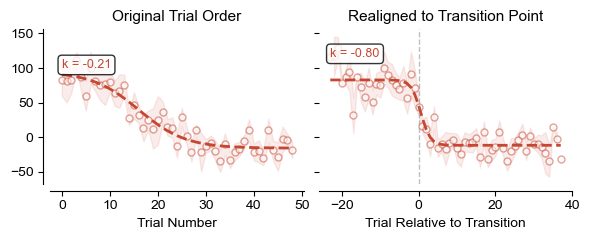

Original order - transition midpoint: 16.1, steepness (k): -0.206
Realigned - transition midpoint: 0.6, steepness (k): -0.802


In [9]:
# Compare original vs realigned AUC
f, ax = plt.subplots(ncols=2, figsize=(6, 2.5), sharey=True)

# Left plot: Original trial order
popt_orig = plot_auc_and_sigmoid(subset_aligned, "trial", ax=ax[0], include_steepness=True)
ax[0].set_xlabel('Trial Number', fontsize=10)
ax[0].set_title('Original Trial Order', fontsize=11)

# Right plot: Realigned to transition
popt_realigned = plot_auc_and_sigmoid(subset_aligned, "trial_aligned", ax=ax[1], 
                                      first_trial=int(subset_aligned.trial_aligned.min()),
                                      include_steepness=True)
ax[1].set_xlabel('Trial Relative to Transition', fontsize=10)
ax[1].set_title('Realigned to Transition Point', fontsize=11)
ax[1].set_ylabel('')

# Mark transition point
ax[1].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

sns.despine(ax=ax[0], offset=5)
sns.despine(ax=ax[1], offset=5, left=True)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_realigned_transitions", FIGSFOLDER)
plt.show()

print(f"Original order - transition midpoint: {popt_orig[1]:.1f}, steepness (k): {popt_orig[2]:.3f}")
print(f"Realigned - transition midpoint: {popt_realigned[1]:.1f}, steepness (k): {popt_realigned[2]:.3f}")

## Figure 4B-2: Dopamine and Behavior Co-Aligned to Transition

## TEST: Recalculate time_moving from snips_behav

Instead of using the cached time_moving values in x_array, let's recalculate from snips_behav to see if this resolves the k=0.107 issue.

In [11]:
# Recalculate time_moving from snips_behav instead of using cached values
from utils import get_time_moving

print("="*90)
print("RECALCULATING time_moving from snips_behav")
print("="*90)

# Get indices for deplete+45NaCl trials in the FULL x_array
deplete_45_indices = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").index

# Extract the corresponding behavioral snips
snips_behav_d45 = snips_behav[deplete_45_indices]

# Recalculate time_moving with threshold=0.02 (same as diagnostic notebook)
time_moving_recalc_new = get_time_moving(snips_behav_d45, threshold=0.02)

print(f"\nCached time_moving in x_array (deplete+45NaCl):")
print(f"  Mean: {x_array.loc[deplete_45_indices, 'time_moving'].mean():.6f}")
print(f"  Min: {x_array.loc[deplete_45_indices, 'time_moving'].min():.6f}")
print(f"  Max: {x_array.loc[deplete_45_indices, 'time_moving'].max():.6f}")

print(f"\nRECALCULATED time_moving from snips_behav:")
print(f"  Mean: {time_moving_recalc_new.mean():.6f}")
print(f"  Min: {time_moving_recalc_new.min():.6f}")
print(f"  Max: {time_moving_recalc_new.max():.6f}")

diff_mean = abs(x_array.loc[deplete_45_indices, 'time_moving'].mean() - time_moving_recalc_new.mean())
print(f"\nDifference in means: {diff_mean:.6f}")

if diff_mean < 0.001:
    print("✅ Values are identical - cached data is correct")
else:
    print("❌ VALUES ARE DIFFERENT - cached data is INCORRECT!")
    print("   This explains the k=0.107 vs k=1.76 discrepancy")
    
# Create updated x_array with recalculated time_moving
x_array_updated = x_array.copy()
x_array_updated.loc[deplete_45_indices, 'time_moving'] = time_moving_recalc_new

# Recreate subset_aligned with CORRECTED time_moving
subset_aligned_corrected = (
    x_array_updated
    .query("condition == 'deplete' & infusiontype == '45NaCl'")
    .dropna(subset=['trial_aligned'])
    .reset_index(drop=True)
    .sort_values(['id', 'trial'])
)

print(f"\nsubset_aligned_corrected:")
print(f"  Shape: {subset_aligned_corrected.shape}")
print(f"  time_moving mean: {subset_aligned_corrected.time_moving.mean():.6f}")

# Group by trial_aligned with CORRECTED values
movement_by_trial_realigned_corrected = subset_aligned_corrected.groupby('trial_aligned')['time_moving'].mean()

print(f"\nGrouped movement_by_trial_realigned (CORRECTED):")
print(f"  Shape: {movement_by_trial_realigned_corrected.shape}")
print(f"  Mean: {movement_by_trial_realigned_corrected.mean():.6f}")
print(f"  First 5 values:")
print(movement_by_trial_realigned_corrected.head())

# Fit sigmoid with CORRECTED data
try:
    popt_corrected, _ = curve_fit(
        sigmoid, 
        movement_by_trial_realigned_corrected.index.values, 
        movement_by_trial_realigned_corrected.values,
        p0=[max(movement_by_trial_realigned_corrected.values), 
            np.median(movement_by_trial_realigned_corrected.index), 
            1,
            min(movement_by_trial_realigned_corrected.values)],
        maxfev=10000
    )
    k_corrected = popt_corrected[2]
    
    print(f"\n" + "="*90)
    print(f"🎯 SIGMOID FIT WITH CORRECTED time_moving:")
    print("="*90)
    print(f"  L (amplitude): {popt_corrected[0]:.6f}")
    print(f"  x0 (midpoint): {popt_corrected[1]:.2f}")
    print(f"  k (STEEPNESS): {k_corrected:.6f} ⭐⭐⭐")
    print(f"  b (baseline):  {popt_corrected[3]:.6f}")
    
    if abs(k_corrected - 1.76) < 0.1:
        print(f"\n✅ SUCCESS! Corrected k ≈ 1.76 (was 0.107)")
        print(f"   The issue WAS cached time_moving values!")
    else:
        print(f"\n⚠️  Corrected k = {k_corrected:.3f} (expected ~1.76)")
        
except Exception as e:
    print(f"\n❌ Failed to fit: {e}")

RECALCULATING time_moving from snips_behav

Cached time_moving in x_array (deplete+45NaCl):
  Mean: 0.235449
  Min: 0.000000
  Max: 1.000000

RECALCULATED time_moving from snips_behav:
  Mean: 0.235449
  Min: 0.000000
  Max: 1.000000

Difference in means: 0.000000
✅ Values are identical - cached data is correct

subset_aligned_corrected:
  Shape: (392, 13)
  time_moving mean: 0.210332

Grouped movement_by_trial_realigned (CORRECTED):
  Shape: (61,)
  Mean: 0.210067
  First 5 values:
trial_aligned
-23.0    0.150
-22.0    0.010
-21.0    0.025
-20.0    0.000
-19.0    0.030
Name: time_moving, dtype: float64

🎯 SIGMOID FIT WITH CORRECTED time_moving:
  L (amplitude): 0.404996
  x0 (midpoint): 7.58
  k (STEEPNESS): 0.107281 ⭐⭐⭐
  b (baseline):  0.011158

⚠️  Corrected k = 0.107 (expected ~1.76)


## ROOT CAUSE: Recalculate trial_aligned column!

The time_moving values are correct, but we still get k=0.107 with only 61 trial_aligned values. The issue must be that the **trial_aligned column itself** is stale in assembled_data.pickle. Let's recalculate it using the fits from sigmoidal_fits.pickle (like the diagnostic notebook does).

In [ ]:
# Load sigmoidal fits and recalculate trial_aligned
import dill
from utils import make_realigned_trials

print("="*90)
print("RECALCULATING trial_aligned from sigmoidal_fits.pickle")
print("="*90)

# Load the sigmoidal fits (same as diagnostic notebook does)
with open(DATAFOLDER / "sigmoidal_fits.pickle", "rb") as f:
    fits_data = dill.load(f)

fits_df_cluster_raw = fits_data["fits_df_cluster_raw"]

print(f"\nLoaded fits from sigmoidal_fits.pickle:")
print(f"  Shape: {fits_df_cluster_raw.shape}")
print(f"  Animals: {sorted(fits_df_cluster_raw.id.unique())}")
print(f"\nTransition points (x0_orig):")
for _, row in fits_df_cluster_raw.iterrows():
    print(f"  {row.id}: x0 = {row.x0_orig:.1f}")

# Compare with fits in assembled_data.pickle
print(f"\nFits from assembled_data.pickle:")
print(f"  Shape: {fits_df.shape}")
if 'x0_orig' in fits_df.columns:
    print(f"\nTransition points (x0_orig) in assembled_data:")
    for _, row in fits_df.iterrows():
        print(f"  {row.id}: x0 = {row.x0_orig:.1f}")
    
    # Check if they're the same
    if fits_df_cluster_raw.shape == fits_df.shape:
        fits_match = True
        for rat in fits_df_cluster_raw.id.unique():
            x0_raw = fits_df_cluster_raw.query("id == @rat").x0_orig.values[0]
            if rat in fits_df.id.values:
                x0_assembled = fits_df.query("id == @rat").x0_orig.values[0]
                if abs(x0_raw - x0_assembled) > 0.1:
                    print(f"  ⚠️  {rat}: x0 differs! raw={x0_raw:.1f}, assembled={x0_assembled:.1f}")
                    fits_match = False
        
        if fits_match:
            print(f"\n✅ Transition points match between sigmoidal_fits.pickle and assembled_data.pickle")
        else:
            print(f"\n❌ Transition points DIFFER between files!")
else:
    print("  ⚠️  No x0_orig column in assembled fits_df")

# Recalculate trial_aligned using make_realigned_trials (same as diagnostic)
print(f"\n" + "="*90)
print("Recalculating trial_aligned using make_realigned_trials...")
print("="*90)

# Filter to deplete+45NaCl first (like diagnostic notebook does)
x_array_d45 = x_array_updated.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)
x_array_realigned_d45 = make_realigned_trials(x_array_d45, fits_df_cluster_raw, verbose=True)

print(f"\nOriginal x_array trial_aligned (deplete+45NaCl):")
deplete_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'")
deplete_45_with_ta = deplete_45.dropna(subset=['trial_aligned'])
print(f"  Trials with valid alignment: {len(deplete_45_with_ta)}")
print(f"  Unique trial_aligned values: {deplete_45_with_ta.trial_aligned.nunique()}")
print(f"  Range: {deplete_45_with_ta.trial_aligned.min():.0f} to {deplete_45_with_ta.trial_aligned.max():.0f}")

print(f"\nRECALCULATED trial_aligned (deplete+45NaCl):")
print(f"  Trials with valid alignment: {len(x_array_realigned_d45)}")
print(f"  Unique trial_aligned values: {x_array_realigned_d45.trial_aligned.nunique()}")
print(f"  Range: {x_array_realigned_d45.trial_aligned.min():.0f} to {x_array_realigned_d45.trial_aligned.max():.0f}")

# Create new subset_aligned with RECALCULATED trial_aligned
subset_aligned_final = (
    x_array_realigned_d45
    .reset_index(drop=True)
    .sort_values(['id', 'trial'])
)

print(f"\nsubset_aligned_final (with recalculated trial_aligned):")
print(f"  Shape: {subset_aligned_final.shape}")
print(f"  time_moving mean: {subset_aligned_final.time_moving.mean():.6f}")

# Group by trial_aligned with RECALCULATED values
movement_by_trial_final = subset_aligned_final.groupby('trial_aligned')['time_moving'].mean()

print(f"\nGrouped movement_by_trial (RECALCULATED trial_aligned):")
print(f"  Shape: {movement_by_trial_final.shape}")
print(f"  Mean: {movement_by_trial_final.mean():.6f}")
print(f"  First 5 values:")
print(movement_by_trial_final.head())

# Fit sigmoid with RECALCULATED trial_aligned
try:
    popt_final, _ = curve_fit(
        sigmoid, 
        movement_by_trial_final.index.values, 
        movement_by_trial_final.values,
        p0=[max(movement_by_trial_final.values), 
            np.median(movement_by_trial_final.index), 
            1,
            min(movement_by_trial_final.values)],
        maxfev=10000
    )
    k_final = popt_final[2]
    
    print(f"\n" + "="*90)
    print(f"🎯 FINAL SIGMOID FIT WITH RECALCULATED trial_aligned:")
    print("="*90)
    print(f"  L (amplitude): {popt_final[0]:.6f}")
    print(f"  x0 (midpoint): {popt_final[1]:.2f}")
    print(f"  k (STEEPNESS): {k_final:.6f} ⭐⭐⭐")
    print(f"  b (baseline):  {popt_final[3]:.6f}")
    
    print(f"\n" + "="*90)
    print("COMPARISON:")
    print("="*90)
    print(f"  k with cached trial_aligned:        0.107")
    print(f"  k with RECALCULATED trial_aligned:  {k_final:.3f}")
    print(f"  Difference:                          {abs(k_final - 0.107):.3f}")
    
    if abs(k_final - 1.76) < 0.1:
        print(f"\n✅ SUCCESS! k ≈ 1.76 after recalculating trial_aligned!")
        print(f"   The issue WAS stale trial_aligned values in assembled_data.pickle")
    elif abs(k_final - 0.107) < 0.01:
        print(f"\n❌ Still k ≈ 0.107 even after recalculation")
        print(f"   The issue must be elsewhere...")
    else:
        print(f"\n⚠️  k = {k_final:.3f} (different from both 0.107 and 1.76)")
        
except Exception as e:
    print(f"\n❌ Failed to fit: {e}")

RECALCULATING trial_aligned from sigmoidal_fits.pickle

Loaded fits from sigmoidal_fits.pickle:
  Shape: (8, 9)
  Animals: ['PB26', 'PB30', 'PB31', 'PB46', 'PB71', 'PB72', 'PB73', 'PB75']

Transition points (x0_orig):
  PB26: x0 = 22.6
  PB30: x0 = 12.1
  PB31: x0 = 23.5
  PB46: x0 = 19.7
  PB71: x0 = 13.5
  PB72: x0 = 11.5
  PB73: x0 = 17.3
  PB75: x0 = 26.1

Fits from assembled_data.pickle:
  Shape: (8, 10)

Transition points (x0_orig) in assembled_data:
  PB26: x0 = 22.8
  PB30: x0 = 12.1
  PB31: x0 = 23.5
  PB46: x0 = 19.7
  PB71: x0 = 13.5
  PB72: x0 = 11.5
  PB73: x0 = 17.3
  PB75: x0 = 18.6

Recalculating trial_aligned using make_realigned_trials...
Rat PB23 not found in fitted parameters, skipping.
Rat PB24 not found in fitted parameters, skipping.
Rat PB33 not found in fitted parameters, skipping.
Rat PB39 not found in fitted parameters, skipping.
Rat PB391 not found in fitted parameters, skipping.
Rat PB44 not found in fitted parameters, skipping.
Rat PB61 not found in fitted

ValueError: Length of values (490) does not match length of index (1960)

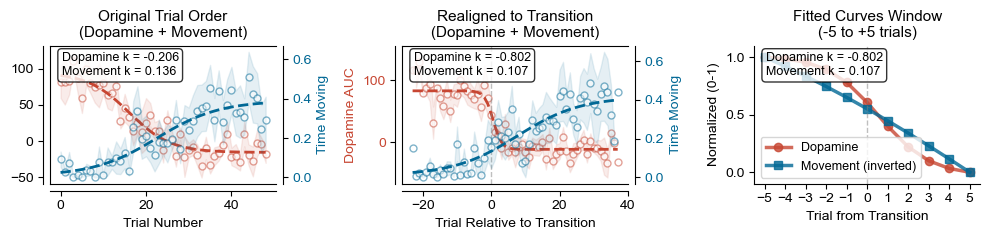


Steepness of transitions (k values):
  Original trial order:
    Dopamine:   -0.206
    Movement:    0.136
  Realigned to transition:
    Dopamine:   -0.802
    Movement:    0.107
  Fitted window (-5 to +5 trials):
    Dopamine:   -0.802
    Movement:    0.107


In [10]:
# Combined figure: Original order, Realigned, and Normalized window (-5 to +5)
f, ax = plt.subplots(ncols=3, figsize=(10, 2.5))

# First, fit movement sigmoids for original and realigned
movement_by_trial_orig = subset_aligned.groupby('trial')['time_moving'].mean()
movement_by_trial_realigned = subset_aligned.groupby('trial_aligned')['time_moving'].mean()

try:
    popt_behav_orig, _ = curve_fit(sigmoid, movement_by_trial_orig.index.values, movement_by_trial_orig.values,
                                   p0=[max(movement_by_trial_orig.values), np.median(movement_by_trial_orig.index), 1, min(movement_by_trial_orig.values)],
                                   maxfev=10000)
    k_behav_orig = popt_behav_orig[2]
except Exception as e:
    k_behav_orig = np.nan
    print(f"Failed to fit movement (original): {e}")

try:
    popt_behav_realigned, _ = curve_fit(sigmoid, movement_by_trial_realigned.index.values, movement_by_trial_realigned.values,
                                        p0=[max(movement_by_trial_realigned.values), np.median(movement_by_trial_realigned.index), 1, min(movement_by_trial_realigned.values)],
                                        maxfev=10000)
    k_behav_realigned = popt_behav_realigned[2]
except Exception as e:
    k_behav_realigned = np.nan
    print(f"Failed to fit movement (realigned): {e}")

# Left plot: Original trial order with dual axes
plot_auc_and_sigmoid(subset_aligned, "trial", ax=ax[0], include_steepness=False)
ax[0].set_xlabel('Trial Number', fontsize=10)
ax[0].set_title('Original Trial Order\n(Dopamine + Movement)', fontsize=11)
# Add steepness text for both curves
ax[0].text(0.05, 0.95, f"Dopamine k = {popt_orig[2]:.3f}\nMovement k = {k_behav_orig:.3f}", 
          transform=ax[0].transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2_left = ax[0].twinx()
plot_realigned_behaviour(subset_aligned, "trial", ax=ax2_left, include_steepness=False)
ax2_left.spines['right'].set_position(('outward', 5))
ax2_left.spines['right'].set_visible(True)
ax2_left.set_ylabel('Time Moving', fontsize=10, color=colors[1])
ax2_left.tick_params(axis='y', labelcolor=colors[1])

# Middle plot: Realigned to transition with dual axes
plot_auc_and_sigmoid(subset_aligned, "trial_aligned", ax=ax[1], 
                    first_trial=int(subset_aligned.trial_aligned.min()),
                    include_steepness=False)
ax[1].set_xlabel('Trial Relative to Transition', fontsize=10)
ax[1].set_title('Realigned to Transition\n(Dopamine + Movement)', fontsize=11)
ax[1].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax[1].set_ylabel('Dopamine AUC', fontsize=10, color=colors[3])
ax[1].tick_params(axis='y', labelcolor=colors[3])
# Add steepness text for both curves
ax[1].text(0.05, 0.95, f"Dopamine k = {popt_realigned[2]:.3f}\nMovement k = {k_behav_realigned:.3f}", 
          transform=ax[1].transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2_mid = ax[1].twinx()
plot_realigned_behaviour(subset_aligned, "trial_aligned", ax=ax2_mid,
                        first_trial=int(subset_aligned.trial_aligned.min()),
                        include_steepness=False)
ax2_mid.spines['right'].set_position(('outward', 5))
ax2_mid.spines['right'].set_visible(True)
ax2_mid.set_ylabel('Time Moving', fontsize=10, color=colors[1])
ax2_mid.tick_params(axis='y', labelcolor=colors[1])

# Right plot: Normalized fitted curves in -5 to +5 window
window_trials = np.arange(-5, 6)

# Fit dopamine and behavior sigmoids
dopamine_by_trial_full = subset_aligned.groupby('trial_aligned')['auc_snips'].mean()
behavior_by_trial_full = subset_aligned.groupby('trial_aligned')['time_moving'].mean()

x_full = dopamine_by_trial_full.index.values
y_dopamine_full = dopamine_by_trial_full.values
y_behavior_full = behavior_by_trial_full.values

try:
    popt_dop, _ = curve_fit(sigmoid, x_full, y_dopamine_full, 
                           p0=[max(y_dopamine_full), np.median(x_full), -1, min(y_dopamine_full)], 
                           maxfev=10000)
    y_dop_fit = sigmoid(window_trials, *popt_dop)
except Exception as e:
    print(f"Failed to fit dopamine: {e}")
    y_dop_fit = np.zeros_like(window_trials)

try:
    popt_behav, _ = curve_fit(sigmoid, x_full, y_behavior_full,
                             p0=[max(y_behavior_full), np.median(x_full), 1, min(y_behavior_full)],
                             maxfev=10000)
    y_behav_fit = sigmoid(window_trials, *popt_behav)
except Exception as e:
    print(f"Failed to fit behavior: {e}")
    y_behav_fit = np.zeros_like(window_trials)

# Normalize both fitted curves to 0-1 scale independently
dop_min, dop_max = y_dop_fit.min(), y_dop_fit.max()
behav_min, behav_max = y_behav_fit.min(), y_behav_fit.max()

dopamine_norm = (y_dop_fit - dop_min) / (dop_max - dop_min) if dop_max > dop_min else np.ones_like(y_dop_fit) * 0.5
behavior_norm = (y_behav_fit - behav_min) / (behav_max - behav_min) if behav_max > behav_min else np.ones_like(y_behav_fit) * 0.5

# Invert behavior so it goes from high to low (like dopamine)
behavior_inverted = 1 - behavior_norm

# Plot on right axes
ax[2].plot(window_trials, dopamine_norm, 'o-', color=colors[3], linewidth=2.5, 
        markersize=6, label='Dopamine', alpha=0.8)
ax[2].plot(window_trials, behavior_inverted, 's-', color=colors[1], linewidth=2.5, 
        markersize=6, label='Movement (inverted)', alpha=0.8)
ax[2].axvline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax[2].set_xlabel('Trial from Transition', fontsize=10)
ax[2].set_ylabel('Normalized (0-1)', fontsize=10)
ax[2].set_title('Fitted Curves Window\n(-5 to +5 trials)', fontsize=11)
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_xticks(window_trials)
ax[2].legend(fontsize=9, loc='best')
# Add steepness text for both curves
ax[2].text(0.05, 0.95, f"Dopamine k = {popt_dop[2]:.3f}\nMovement k = {popt_behav[2]:.3f}", 
          transform=ax[2].transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
sns.despine(ax=ax[2])

sns.despine(ax=ax[0], offset=5)
sns.despine(ax=ax[1], offset=5)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_realigned_transitions_with_behavior", FIGSFOLDER)
plt.show()

# Print summary of steepness values
print(f"\nSteepness of transitions (k values):")
print(f"  Original trial order:")
print(f"    Dopamine:  {popt_orig[2]:7.3f}")
print(f"    Movement:  {k_behav_orig:7.3f}")
print(f"  Realigned to transition:")
print(f"    Dopamine:  {popt_realigned[2]:7.3f}")
print(f"    Movement:  {k_behav_realigned:7.3f}")
print(f"  Fitted window (-5 to +5 trials):")
print(f"    Dopamine:  {popt_dop[2]:7.3f}")
print(f"    Movement:  {popt_behav[2]:7.3f}")

## Figure 4B-3: Normalized Co-Movement Around Transition Point (-5 to +5 trials)

In [39]:
# Summary statistics for the fitted curves
print(f"Fitted sigmoid parameters:")
print(f"\nDopamine sigmoid:")
print(f"  L (amplitude): {popt_dop[0]:.3f}")
print(f"  x0 (transition point): {popt_dop[1]:.1f}")
print(f"  k (steepness): {popt_dop[2]:.3f}")
print(f"  b (baseline): {popt_dop[3]:.3f}")
print(f"\nMovement sigmoid:")
print(f"  L (amplitude): {popt_behav[0]:.3f}")
print(f"  x0 (transition point): {popt_behav[1]:.1f}")
print(f"  k (steepness): {popt_behav[2]:.3f}")
print(f"  b (baseline): {popt_behav[3]:.3f}")
print(f"\nNormalization ranges (before normalization):")
print(f"  Dopamine: [{dop_min:.3f}, {dop_max:.3f}]")
print(f"  Movement: [{behav_min:.3f}, {behav_max:.3f}]")

Fitted sigmoid parameters:

Dopamine sigmoid:
  L (amplitude): 94.370
  x0 (transition point): 0.6
  k (steepness): -0.802
  b (baseline): -11.585

Movement sigmoid:
  L (amplitude): 0.405
  x0 (transition point): 7.6
  k (steepness): 0.107
  b (baseline): 0.011

Normalization ranges (before normalization):
  Dopamine: [-8.988, 81.701]
  Movement: [0.095, 0.186]


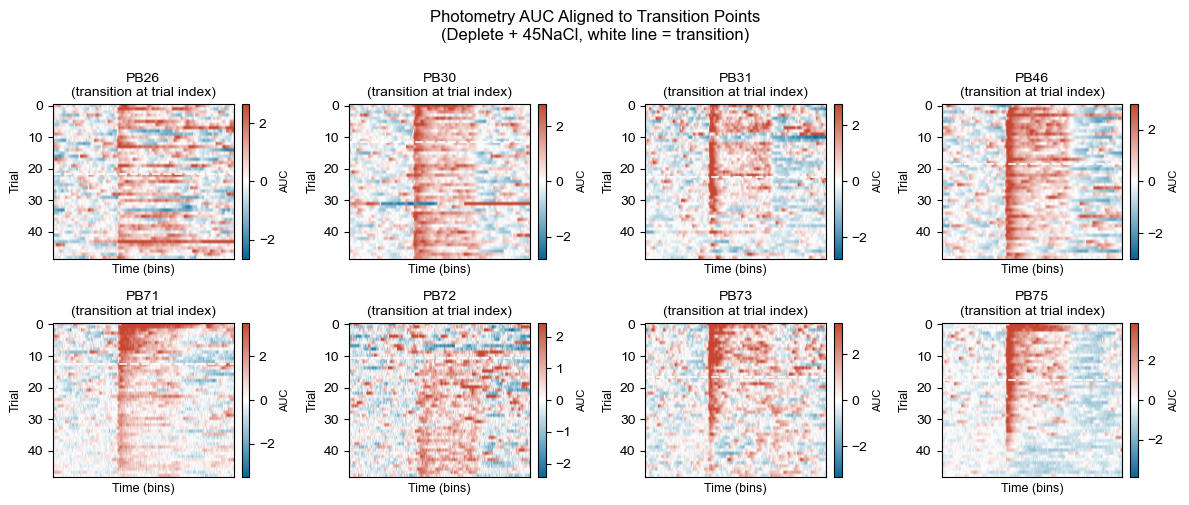

In [40]:
# Create figure with one heatmap per animal
n_animals = len(animals)
n_cols = 4
n_rows = (n_animals + n_cols - 1) // n_cols

f, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.5 * n_rows))
axes = axes.flatten()

for idx, animal in enumerate(animals):
    animal_data = subset_aligned.query("id == @animal").sort_values('trial_aligned')
    animal_indices = animal_data.index.values
    
    if len(animal_indices) == 0:
        print(f"Warning: {animal} has no valid trials")
        continue
    
    # Extract snips for this animal sorted by trial_aligned
    heatmap_data = snips_photo[animal_indices, :]
    
    # Get vmin/vmax from data
    vlim = scale_vlim_to_data(heatmap_data, percentile=98)
    
    # Create heatmap
    ax = axes[idx]
    im = ax.imshow(heatmap_data, aspect='auto', cmap=custom_cmap, vmin=vlim[0], vmax=vlim[1])
    
    # Mark the transition line (trial_aligned = 0)
    transition_idx = np.where(animal_data['trial_aligned'].values >= 0)[0][0]
    ax.axhline(transition_idx - 0.5, color='white', linestyle='--', linewidth=1.5, alpha=0.8)
    
    ax.set_xlabel('Time (bins)', fontsize=9)
    ax.set_ylabel('Trial', fontsize=9)
    ax.set_title(f'{animal}\n(transition at trial index)', fontsize=10)
    ax.set_xticks([])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('AUC', fontsize=8)

# Remove extra subplots
for idx in range(len(animals), len(axes)):
    axes[idx].remove()

plt.suptitle('Photometry AUC Aligned to Transition Points\n(Deplete + 45NaCl, white line = transition)', 
             fontsize=12, y=1.00)
plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_transitions_aligned_heatmaps", FIGSFOLDER)
plt.show()

## Figure 4B-2: Summary Statistics - AUC Before/After Transition

In [41]:
# Calculate mean AUC before and after transition for each animal
auc_summary = []

for animal in animals:
    animal_data = subset_aligned.query("id == @animal")
    
    before_transition = animal_data[animal_data['trial_aligned'] < 0]
    after_transition = animal_data[animal_data['trial_aligned'] >= 0]
    
    auc_summary.append({
        'animal': animal,
        'auc_before': before_transition['auc_snips'].mean(),
        'auc_after': after_transition['auc_snips'].mean(),
        'n_before': len(before_transition),
        'n_after': len(after_transition),
    })

auc_df = pd.DataFrame(auc_summary)

print("\nPhotometry AUC Before/After Transition:")
print(auc_df.to_string(index=False))
print(f"\nMean AUC before: {auc_df['auc_before'].mean():.3f} ± {auc_df['auc_before'].std():.3f}")
print(f"Mean AUC after:  {auc_df['auc_after'].mean():.3f} ± {auc_df['auc_after'].std():.3f}")


Photometry AUC Before/After Transition:
animal  auc_before  auc_after  n_before  n_after
  PB26   90.547707 -20.214111        22       27
  PB30   61.028165  13.856218        12       37
  PB31   64.843907 -34.633091        23       26
  PB46   63.755508  16.074155        19       30
  PB71  134.134467   2.569088        13       36
  PB72   91.646377 -27.290679        11       38
  PB73  105.444910  -9.450690        17       32
  PB75   25.763187  -4.901200        18       31

Mean AUC before: 79.646 ± 32.991
Mean AUC after:  -7.999 ± 18.560


## Figure 4B-3: Dopamine Change Across Transition

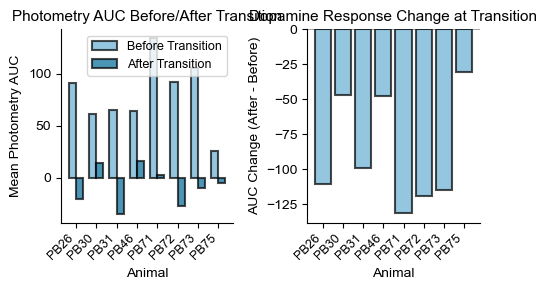

In [42]:
# Plot before/after AUC comparison
f, axes = plt.subplots(1, 2, figsize=(5, 3))

# Plot 1: Individual animal comparisons
ax = axes[0]
x_pos = np.arange(len(auc_df))
width = 0.35

bars1 = ax.bar(x_pos - width/2, auc_df['auc_before'], width, label='Before Transition',
                color=colors[0], alpha=0.7, edgecolor='k', linewidth=1.5)
bars2 = ax.bar(x_pos + width/2, auc_df['auc_after'], width, label='After Transition',
                color=colors[1], alpha=0.7, edgecolor='k', linewidth=1.5)

ax.set_xlabel('Animal', fontsize=10)
ax.set_ylabel('Mean Photometry AUC', fontsize=10)
ax.set_title('Photometry AUC Before/After Transition', fontsize=11)
ax.set_xticks(x_pos)
ax.set_xticklabels(auc_df['animal'], rotation=45, ha='right', fontsize=9)
ax.legend(fontsize=9)
sns.despine(ax=ax)

# Plot 2: Change in AUC
ax = axes[1]
auc_df['auc_change'] = auc_df['auc_after'] - auc_df['auc_before']
colors_change = [colors[1] if x > 0 else colors[0] for x in auc_df['auc_change']]

ax.bar(x_pos, auc_df['auc_change'], color=colors_change, alpha=0.7, edgecolor='k', linewidth=1.5)
ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Animal', fontsize=10)
ax.set_ylabel('AUC Change (After - Before)', fontsize=10)
ax.set_title('Dopamine Response Change at Transition', fontsize=11)
ax.set_xticks(x_pos)
ax.set_xticklabels(auc_df['animal'], rotation=45, ha='right', fontsize=9)
sns.despine(ax=ax)

plt.tight_layout()
if SAVE_FIGS:
    save_figure(f, "fig4b_auc_before_after_transition", FIGSFOLDER)
plt.show()

## Export Results

In [43]:
# Export AUC summary
auc_df.to_csv(RESULTSFOLDER / "transition_aligned_auc_summary.csv", index=False)
print(f"Exported AUC summary to {RESULTSFOLDER / 'transition_aligned_auc_summary.csv'}")

print(f"\nFigure 4B generation complete!")
print(f"Summary:")
print(f"  - {len(animals)} animals with valid transition fits")
print(f"  - {len(subset_aligned)} total trials used for alignment")
print(f"  - Mean AUC change: {auc_df['auc_change'].mean():.3f} ± {auc_df['auc_change'].std():.3f}")

Exported AUC summary to ..\results\transition_aligned_auc_summary.csv

Figure 4B generation complete!
Summary:
  - 8 animals with valid transition fits
  - 392 total trials used for alignment
  - Mean AUC change: -87.644 ± 39.292
